In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import spatial
from sklearn.naive_bayes import GaussianNB

In [2]:
dataset, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True,
    with_info=True
)

dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]

In [3]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [4]:
dataset_train_original

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [5]:
for x,y in dataset_test_original.shuffle(25000).take(8):
    print(x.numpy().decode("utf-8"))
    print(y.numpy())
    print()

This movie is funny and sad enough I think that it is kinda true. If you love Office Space then you will love this movie because it is another Mike Judge hit, but it is nothing like Office Space. I told every one to see this movie. I only wish that it would have been in more theaters so it would have gotten the recognition it deserved. I love this movie and would love to see more from Mike Judge. Luke Wilson is also what makes this movie what it is. I am so glad that I will not be alive in the year 2505, because if this movie turns out to be true we are all in for a lot of trouble. I just hope more people see this movie because I know that they will fall in love with it too.
1

I was looking forward to seeing two bright young actors appearing in "Dear John," but it was very slow moving; and I felt that both the screenplay and the direction hampered the flexibility of the principle performers. I usually do enjoy film adaptations of these novels. Ironically, I did think the movie did an 

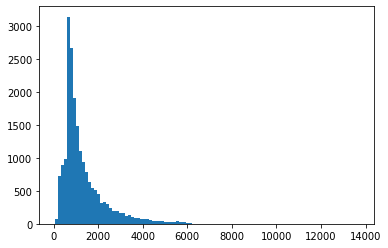

In [6]:
lengths = []
for x, _ in tfds.as_numpy(dataset_train_original):
  lengths += [len(x)]

plt.hist(lengths,bins=100)
plt.show()


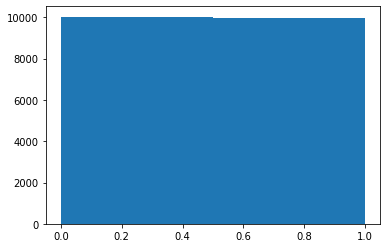

In [7]:
labels = []
for _, y in tfds.as_numpy(dataset_train_original):
  labels += [y]

plt.hist(labels,bins=2)
plt.show()

Bag of words

In [8]:
vocabulary_size = 10000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="multi_hot"

)

encoder.adapt(
    dataset_train_original.map(lambda text, label: text).batch(2048)
    )



In [9]:
vocabulary = encoder.get_vocabulary()
print("Vocabulary:", ", ".join(vocabulary[:100]))
print(vocabulary[0])

Vocabulary: [UNK], the, and, a, of, to, is, in, it, i, this, that, br, was, as, for, with, movie, but, film, on, not, you, his, are, have, be, he, one, its, at, all, by, an, they, who, from, so, like, her, or, just, about, if, has, out, some, there, what, good, very, when, more, she, my, even, would, up, no, which, time, only, really, story, their, had, were, see, can, me, than, we, much, well, been, get, will, also, do, into, people, other, because, bad, first, great, how, most, him, dont, then, made, movies, make, could, films, way, any, them, after
[UNK]


In [10]:
text = "I must not fear. Fear is the mind-killer. Fear is the little-death that brings total obliteration. I will face my fear. I will permit it to pass over me and through me. And when it has gone past I will turn the inner eye to see its path. Where the fear has gone there will be nothing. Only I will remain."
print("Original:", text)

def multi_hot_to_string(multi_hot):
  return " ".join([str(int(x)) for x in multi_hot])

text_encoded = encoder(text).numpy()
print("Encoded:", multi_hot_to_string(text_encoded))

Original: I must not fear. Fear is the mind-killer. Fear is the little-death that brings total obliteration. I will face my fear. I will permit it to pass over me and through me. And when it has gone past I will turn the inner eye to see its path. Where the fear has gone there will be nothing. Only I will remain.
Encoded: 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [11]:
for x, y in dataset_train_original.take(8):
  x_encoded = encoder(x).numpy()
  print("Input:", multi_hot_to_string(x_encoded))
  print("Output:", y.numpy())

Input: 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

In [12]:
# create a simple baseline with Naive Bayes.

In [29]:
def dataset_to_numpy(dataset):
  x_input = []
  y_output = []
  for x, y in dataset.batch(2048):
    x = encoder(x).numpy()
    x_input.extend(x)
    y_output.extend(x)
  x_input = np.array(x_input)
  y_output = np.array(y_output)
  return x_input, y_output

x_train, y_train = dataset_to_numpy(dataset_train_original)
print(x_train.shape, y_train.shape)

x_test, y_test = dataset_to_numpy(dataset_test_original)
print(x_test.shape, y_test.shape)

(20000, 10000) (20000, 10000)
(25000, 10000) (25000, 10000)


In [30]:
x_train[0], y_train[0]

(array([1., 1., 1., ..., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., ..., 0., 0., 0.], dtype=float32))

In [31]:
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
correct_predictions = (y_test == y_pred).sum()
accuracy = correct_predictions / len (x_test)

print(f"{100 * accuracy:.2f}%")

ValueError: ignored

In [32]:
# training a neural network

In [33]:
dataset_train = dataset_train_original.cache()
dataset_train = dataset_train.shuffle(200000)
dataset_train = dataset_train.batch(128)


#data_set_train = dataset_train_original.cache().shuffle(200000).batch(128)

dataset_validate = dataset_validate_original.cache()
dataset_validate = dataset_validate_original.batch(128)

In [16]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_validate
)

# for x, y in dataset_train.take(1):
#   print(x)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 5s 24ms/step - loss: 0.3447 - accuracy: 0.8553 - val_loss: 0.3091 - val_accuracy: 0.8700
Epoch 2/5
157/157 [==============================] - 4s 23ms/step - loss: 0.1871 - accuracy: 0.9304 - val_loss: 0.2900 - val_accuracy: 0.8828
Epoch 3/5
157/157 [==============================] - 4s 23ms/step - loss: 0.1349 - accuracy: 0.9

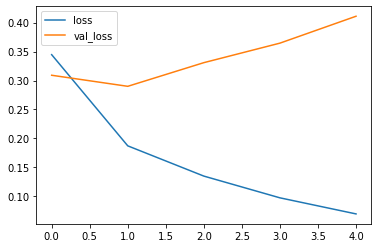

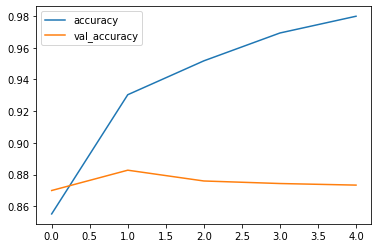

In [17]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [18]:
model.evaluate(dataset_test_original.batch(128))

196/196 [==============================] - 4s 19ms/step - loss: 0.4467 - accuracy: 0.8614


[0.4467238187789917, 0.8614400029182434]

In [19]:
 #0.8540

In [20]:
#0.0000e+00
#

In [21]:
#0.8600
[0.4949251711368561, 0.8600000143051147]

[0.4949251711368561, 0.8600000143051147]

In [22]:
#0.8613

In [23]:
#0.8552

In [24]:
model.predict(["This is a really not so good movie."])


array([[0.46880782]], dtype=float32)

In [27]:
for x, y in dataset_validate_original.batch(1):
  prediction = model.predict(x)
  loss, acc = model.evaluate(x, y, verbose=0)
  print(prediction, y.numpy(), loss, acc)
  break


[[0.00560522]] [0] 0.005620991811156273 1.0


In [34]:
# Word Embeddings

In [35]:
vocabulary_size = 10000
sequence_length = 128

In [37]:
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"

)

encoder.adapt(dataset_train_original.map(lambda text, label: text).batch(1024))

In [41]:
encoder.get_vocabulary()[1]

'[UNK]'

In [42]:
encoder("This is a really good movie. The dialogs are clearly audible. The scenery is well lit.")

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([  11,    7,    4,   63,   50,   18,    2, 3197,   25,  681,    1,
          2, 1390,    7,   74, 4929,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>